# Teste de viabilidade

Este notebook testa a viabilidade dos algoritmos do módulo `lexicogenero`, de minha autoria, para selecionar, dividir e organizar dados de textos em prosa em grego antigo para a disciplina FLL5133-2021.

## Carregamento e organização dos dados importados do Diorisis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from lexicogenero.ferramentas.diorisis_reader import carrega_textos, em_pandas
from lexicogenero.main import DIORISIS_PATH
from lexicogenero.grc import STOPS_LIST

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

Neste teste, usaremos como corpus os textos de historiografia e prosa filosófica (diálogos e tratados) de autores do período clássico:

- Historiografia:
    - Heródoto
    - Xenofonte:
        - Ciropédia
        - Anábase
        - Helênica
    - Tucídides
- Prosa filosófica:
    - Platão
    - Xenofonte:
        - Agesilau
        - Hierão
        - Simpósio
        - Apologia
        - Memorabilia

In [3]:
ignorados = [
    "Xenophon (0032) - On the Art of Horsemanship (013).json",
    "Xenophon (0032) - Economics (003).json",
    "Xenophon (0032) - Ways and Means (011).json",
    "Xenophon (0032) - Constitution of the Lacedaemonians (010).json",
    "Xenophon (0032) - On the Cavalry Commander (012).json",
    "Xenophon (0032) - On Hunting (014).json",
    "Xenophon (0032) - Apology (005).json",
]

corpus = carrega_textos(autores=['Herodotus', 
                                 'Thucydides', 
                                 'Plato', 
                                 'Xenophon (0032)', # Exclui Xenofonte de Éfeso 
                                 ],
                        diorisis_path=DIORISIS_PATH,
                        ignore=ignorados,
                        verbose=False)

In [4]:
df = em_pandas(corpus)

Criando DF para: Herodotus (0016) - Histories (001).json
Criando DF para: Thucydides (0003) - History (001).json
Criando DF para: Plato (0059) - Cleitophon (029).json
Criando DF para: Plato (0059) - Menexenus (028).json
Criando DF para: Plato (0059) - Symposium (011).json
Criando DF para: Plato (0059) - Hipparchus (015).json
Criando DF para: Plato (0059) - Lovers (016).json
Criando DF para: Plato (0059) - Minos (033).json
Criando DF para: Plato (0059) - Phaedrus (012).json
Criando DF para: Plato (0059) - Epinomis (035).json
Criando DF para: Plato (0059) - Apology (002).json
Criando DF para: Plato (0059) - Protagoras (022).json
Criando DF para: Plato (0059) - Timaeus (031).json
Criando DF para: Plato (0059) - Hippias Minor (026).json
Criando DF para: Plato (0059) - Sophist (007).json
Criando DF para: Plato (0059) - Gorgias (023).json
Criando DF para: Plato (0059) - Laches (019).json
Criando DF para: Plato (0059) - Critias (032).json
Criando DF para: Plato (0059) - Euthyphro (001).json
C

In [5]:
df

,sent_id,location,form,lemma,POS,analyses,id,file,author,text
0,1,1.t.1,Ἡροδότου,Ἡρόδοτος,proper,masc gen sg,1,Herodotus (0016) - Histories (001).json,Herodotus,Histories
1,1,1.t.1,Ἁλικαρνησσέος,Ἁλικαρνησσεύς,proper,masc gen sg (epic ionic),2,Herodotus (0016) - Histories (001).json,Herodotus,Histories
2,1,1.t.1,ἱστορίης,ἱστορία,noun,fem gen sg (epic ionic),3,Herodotus (0016) - Histories (001).json,Herodotus,Histories
3,1,1.t.1,ἀπόδεξις,ἀπόδεξις,noun,fem nom sg,4,Herodotus (0016) - Histories (001).json,Herodotus,Histories
4,1,1.t.1,ἥδε,ὅδε,pronoun,fem nom sg,5,Herodotus (0016) - Histories (001).json,Herodotus,Histories
...,...,...,...,...,...,...,...,...,...,...
63970,3804,7.8.24.1,πρὸς,πρός,preposition,indeclform (prep),14,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis
63971,3804,7.8.24.1,Τισσαφέρνην,Τισσαφέρνης,proper,masc acc sg;masc acc sg (attic epic ionic),15,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis
63972,3804,7.8.24.1,καὶ,καί,conjunction,indeclform (conj),16,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis
63973,3804,7.8.24.1,Φαρνάβαζον,Φαρνάβαζος,proper,masc acc sg,17,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis


Liberando parte da memória RAM deletando valores que não serão mais utilizados:

In [6]:
del corpus

## Anotando Gênero

In [7]:
hist = [
    "Herodotus (0016) - Histories (001).json",
    "Thucydides (0003) - History (001).json",
    "Xenophon (0032) - Hellenica (001).json",
    "Xenophon (0032) - Cyropaedia (007).json",
    "Xenophon (0032) - Anabasis (006).json",
]

In [8]:
# Deve haver uma maneira menos rocambolesca para resolver isso
df['genero'] = np.nan
df.loc[df.file.isin(hist), 'genero'] = "hist"
df.genero.fillna("filo", inplace=True)

Para meu modelo funcionar, será necessário ter uma quantidade relativamente equilibrada de dados entre autores de prosa historiográfica e prosa filosófica, a seleção parece razoável.
Qualquer tentativa de aumentar os dados de historiografia forçaria aumentar o escopo temporal (o próximo autor seria Políbio, já do período helenístico)

<AxesSubplot:>

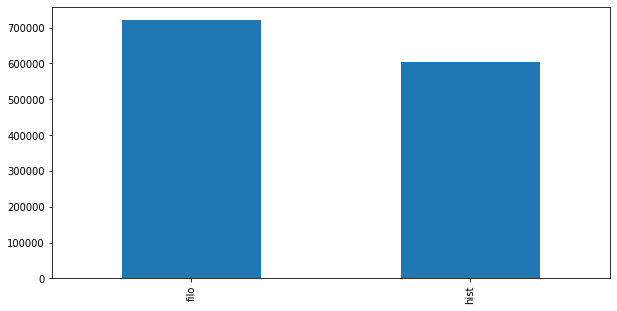

In [9]:
df.genero.value_counts().plot(kind='bar')

## Verbos por gênero

In [10]:
df_verbos = df.loc[(df.POS == "verb") & (-df.lemma.isin(STOPS_LIST))]
df_verbos
del df

A filtragem não causa mudança na proporção entre documentos de historiografia e filosofia.

<AxesSubplot:>

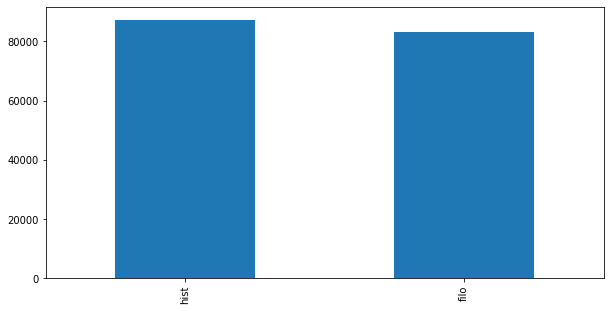

In [11]:
df_verbos.genero.value_counts().plot(kind='bar')

In [12]:
filo_verbos = df_verbos[df_verbos.genero == "filo"].lemma
filo_verbos.value_counts()

οἴομαι           1767
οἶδα             1482
φαίνω            1204
βούλομαι         1177
δεῖ              1026
                 ... 
προπαιδεύω          1
μολύνω              1
διαίνω              1
ὑπεραγανακτέω       1
ἐφέζομαι            1
Name: lemma, Length: 3663, dtype: int64

<AxesSubplot:ylabel='Density'>

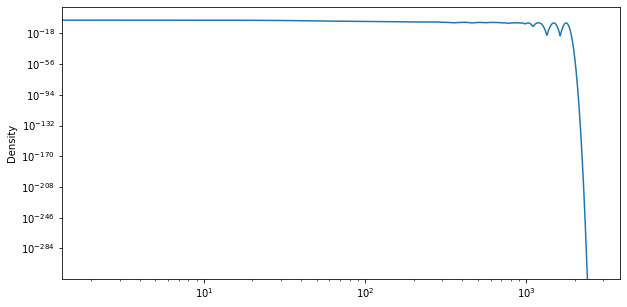

In [13]:
filo_verbos.value_counts().plot(kind='density', logx=True, logy=True)

In [14]:
hist_verbos = df_verbos[df_verbos.genero == "hist"].lemma
hist_verbos.value_counts()

βούλομαι        1177
λαμβάνω          994
ἀφικνέομαι       915
ἔρχομαι          872
πάρειμι          822
                ... 
ἐπεικάζω           1
ἀποκηδεύω          1
πυκνόω             1
καθιππάζομαι       1
ἐξαυλίζομαι        1
Name: lemma, Length: 4331, dtype: int64

<AxesSubplot:ylabel='Density'>

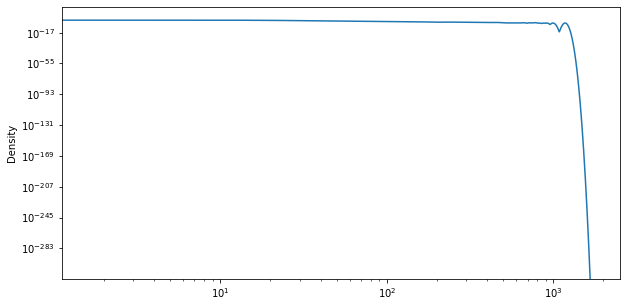

In [15]:
hist_verbos.value_counts().plot(kind='density', logx = True, logy=True)

Reorganizando como lista de duplas:

In [16]:
hist_verbos = [(p, n) for n, p in hist_verbos.items()]
filo_verbos = [(p, n) for n, p in filo_verbos.items()]

In [17]:
C_hist_verbos = len(hist_verbos)
C_filo_verbos = len(filo_verbos)

In [25]:
p_hist_verbos = {p: np.log10(n/C_hist_verbos) for p, n in hist_verbos}
p_filo_verbos = {p: np.log10(n/C_filo_verbos) for p, n in filo_verbos}

/tmp/ipykernel_254011/1971193736.py:2: RuntimeWarning: divide by zero encountered in log10
  p_filo_verbos = {p: np.log10(n/C_filo_verbos) for p, n in filo_verbos}


In [26]:
p_filo_verbos

{'διηγέομαι': -3.5054004605811433,
 'διαλέγω': -0.8918838920300713,
 'ψέγω': -1.0355218258059635,
 'ὑπερεπαινέω': -1.641848843814944,
 'ἀπομνημονεύω': -3.1422225581683176,
 'ἐπαινέω': -1.007673600361101,
 'μέμφομαι': -0.9563971985553557,
 'προσποιέω': -1.5421576588020836,
 'φροντίζω': -1.249293575813112,
 'διεξέρχομαι': -0.3314861207797367,
 'τυγχάνω': -0.8747379374737414,
 'ἡγέομαι': -0.8994327486896412,
 'ἀκούω': -0.8780740011383361,
 'φαίνω': -0.8837848317965569,
 'δέω': -1.0577654445870195,
 'δίδωμι': -0.9509113005773245,
 'δέχομαι': -1.3167964404004946,
 'ἐθέλω': -0.9135228482276895,
 'ὠφελέω': -1.0136079190112335,
 'προθυμέομαι': -1.5597803949867126,
 'ὑπομένω': -0.8744252704466271,
 'γιγνώσκω': -0.8827481386372422,
 'ἀσκέω': -0.8968332869971072,
 'διώκω': -1.5483828970870464,
 'φεύγω': -1.1266532517384382,
 'συγγίγνομαι': -0.9212867859260729,
 'ἐκπλήσσω': -1.2618854272429443,
 'ἐπιτιμάω': -0.521410072426441,
 'ὑμνέω': -0.9151074755791925,
 'φέρω': -0.9274669903286489,
 'ἀγνοέω':